## Set Up and Load Data

In [1]:
import sys
print(sys.executable)

/Users/ih/anaconda3/envs/myenv/bin/python


In [2]:
# sample message
# hi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 15)

In [3]:
df = pd.read_csv('dataset/train.csv', index_col='PassengerId')
df.drop(['Name'], axis=1, inplace=True)

## EDA

In [4]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 823.5+ KB


In [6]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0].index

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')

In [7]:
missing_values

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [8]:
columns_with_missing = missing_values[missing_values > 0].index.tolist()
columns_with_missing

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [9]:
# Split cabin structure
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['Side'] = df['Cabin'].str.split('/').str[-1]

In [10]:
# Select columns based on dtypes
df['Deck'] = df['Cabin'].str.split('/').str[0] # Split cabin structure
bool_cols = ['CryoSleep', 'Transported','VIP']
df[bool_cols] = df[bool_cols].astype(bool)
df[bool_cols] = df[bool_cols].astype(int)
object_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()
for col in object_cols:
    print(f'Unique values of {col}: {df[col].unique()}')
print('\n')
print(f'Boolean columns: {bool_cols}\nCategory columns: {object_cols}\nNumerical columns:{num_cols}')

Unique values of HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Unique values of Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Unique values of Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Unique values of Deck: ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
Unique values of Side: ['P' 'S' nan]


Boolean columns: ['CryoSleep', 'Transported', 'VIP']
Category columns: ['HomePlanet', 'Cabin', 'Destination', 'Deck', 'Side']
Numerical columns:['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']


In [11]:
home_transported = df[['HomePlanet','Transported']].copy()
home_transported['HomePlanet'].fillna('Missing', inplace=True)
home_transported = pd.DataFrame(home_transported.groupby(['HomePlanet','Transported']).size()).reset_index()
home_transported.columns = ['HomePlanet','Transported','Count']
for i in home_transported.HomePlanet.unique().tolist():
    for j in home_transported.Transported.unique().tolist():
        count = home_transported[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j)]['Count']
        home_transported.loc[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j), 'percentage'] = round(count/(home_transported.groupby('HomePlanet')['Count'].sum()[i])*100,2)

In [12]:
df.head(10)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P
0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S
0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S
0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S
0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S
0005_01,Earth,0,F/0/P,PSO J318.5-22,44.0,0,0.0,483.0,0.0,291.0,0.0,1,F,P
0006_01,Earth,0,F/2/S,TRAPPIST-1e,26.0,0,42.0,1539.0,3.0,0.0,0.0,1,F,S
0006_02,Earth,1,G/0/S,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,NaN,1,G,S
0007_01,Earth,0,F/3/S,TRAPPIST-1e,35.0,0,0.0,785.0,17.0,216.0,0.0,1,F,S


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8693 non-null   int64  
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8693 non-null   int64  
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   int64  
 12  Deck          8494 non-null   object 
 13  Side          8494 non-null   object 
dtypes: float64(6), int64(3), object(5)
memory usage: 1018.7+ KB


Text(0.5, 1.0, 'Distribution of Missing Values')

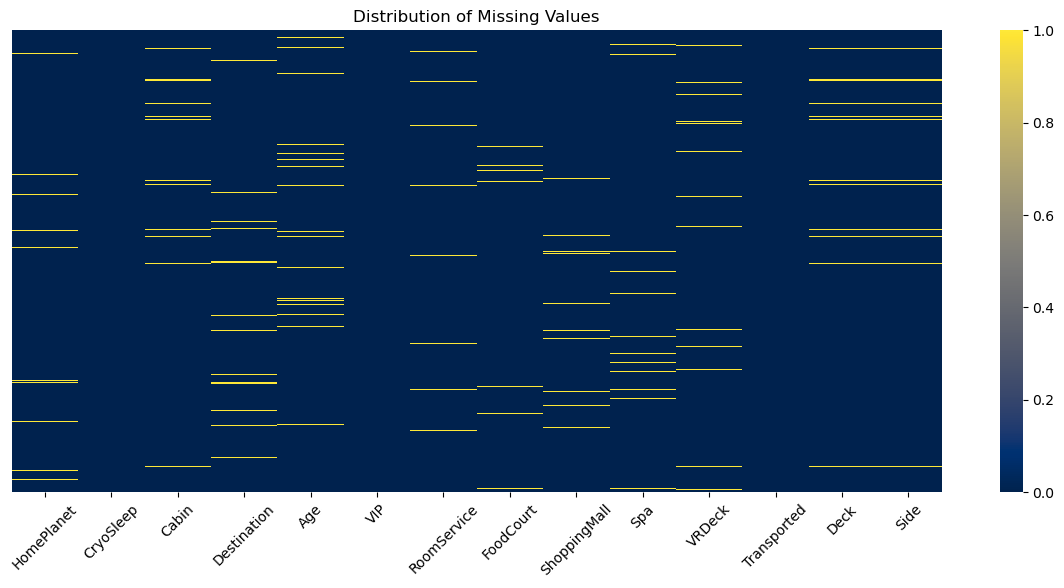

In [14]:
plt.figure(figsize=(15,6))
ax = sns.heatmap(data=df.reset_index().drop('PassengerId', axis=1).isnull(), cbar=True, cmap='cividis', yticklabels=False)
plt.xticks(rotation=45)
plt.title('Distribution of Missing Values')

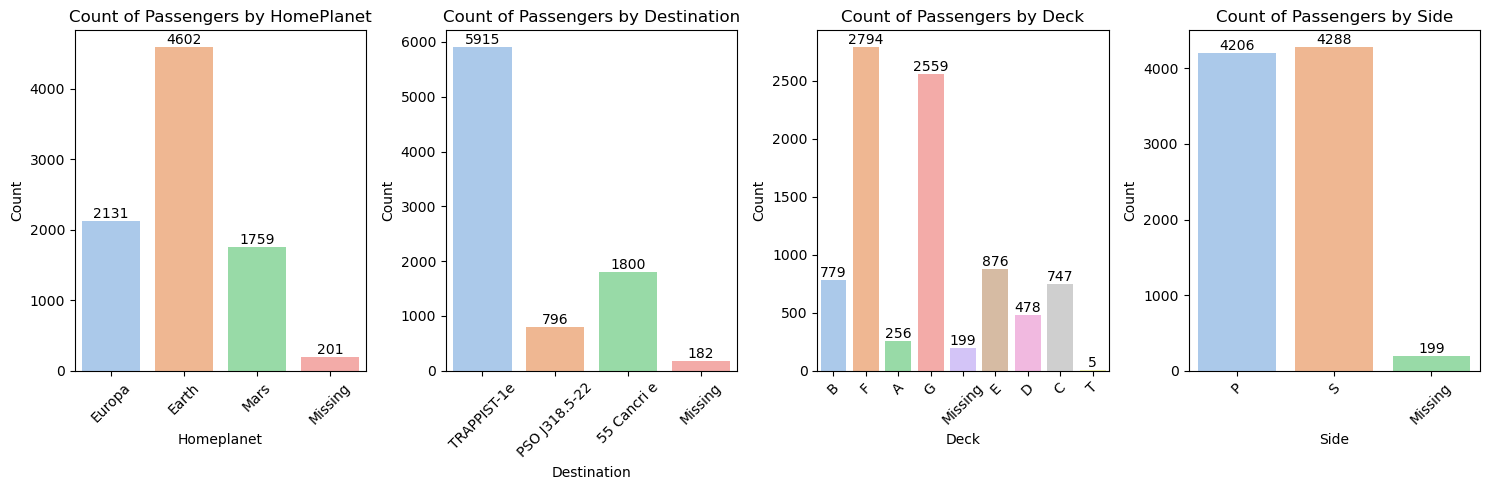

In [15]:
selected_col = [col for col in object_cols if col != 'Cabin']
sample_df = df.copy()
sample_df.fillna('Missing', inplace=True)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
ax = ax.ravel()
for i, col in enumerate(selected_col):
    sns.countplot(x=col, data=sample_df, palette='pastel',hue=col, ax=ax[i])
    for container in ax[i].containers:
        ax[i].bar_label(container, color='black', size=10)
    ax[i].set_title(f'Count of Passengers by {col}')
    ax[i].set_xlabel(col.capitalize())
    ax[i].set_ylabel('Count')
    ax[i].tick_params(axis='x', rotation = 45)
plt.tight_layout()
plt.show()

<Axes: >

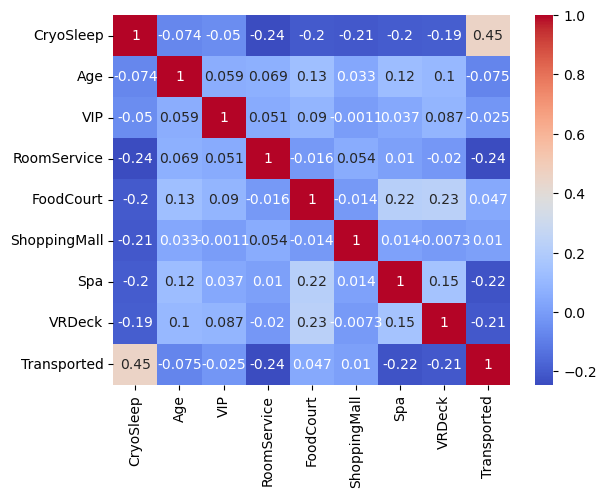

In [16]:
# Correlation Matrix of Numerical columns
num_corr = df[num_cols].corr()
sns.heatmap(num_corr, annot=True, cmap='coolwarm')

## Clean HomePlanet

1. Data Structure for Stacked Bars
In a stacked bar chart, you need a DataFrame where:
- The index represents the categories for the bars (e.g., HomePlanet).
- The columns represent the different segments of the bars (e.g., Transported status).
- The values in the DataFrame represent the heights of these segments.

In [ ]:
# Function to see rela between HomePlanet and other features
def homeplanet_other(dataframe, column_name):
    sample_df = dataframe[['HomePlanet',column_name]].copy().reset_index().drop('PassengerId', axis=1)
    sample_df.fillna('Missing', inplace=True) 
    sample_df = pd.DataFrame(sample_df.groupby(['HomePlanet'])[column_name].value_counts())
    totals = sample_df.groupby(['HomePlanet'])['count'].transform(sum)
    sample_df['percentage'] = sample_df['count']/totals*100
    sample_df_pivot = sample_df.pivot_table(index='HomePlanet', columns=column_name, values='percentage', aggfunc='sum', fill_value=0)
    plot = sample_df_pivot.plot(kind='bar', stacked=True, figsize=(10, 5.5), rot=0, legend=True, ylabel='Percentage', title=f'Distribution of {column_name} by HomePlanet')
    return sample_df, plot, sample_df_pivot

In [17]:
# Relationship between HomePlanet and Transported status
home_transported, plot_home_transported, data_pivot = homeplanet_other(df, 'Transported')
# Distribution of Destination by HomePlanet
home_dest, plot_home_dest, data_pivot = homeplanet_other(df, 'Destination')

NameError: name 'homeplanet_other' is not defined

In [18]:
df_homeplanet = df.copy()

In [19]:
features = df_homeplanet[df_homeplanet['HomePlanet'].notna()].drop(columns='HomePlanet')
target = df_homeplanet[df_homeplanet['HomePlanet'].notna()].HomePlanet
test_homeplanet_df = df_homeplanet[df_homeplanet['HomePlanet'].isna()]

In [20]:
target.head()

PassengerId
0001_01    Europa
0002_01     Earth
0003_01    Europa
0003_02    Europa
0004_01     Earth
Name: HomePlanet, dtype: object

In [21]:
# Split features and target into different set
X_train, X_val, y_train, y_val = train_test_split(features, target, train_size=0.8, test_size=0.2, random_state=1)

X_test = test_homeplanet_df.drop(columns='HomePlanet')
y_test = test_homeplanet_df['HomePlanet']

In [22]:
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_target = one_hot_encoder.fit_transform(target.values.reshape(-1,1))

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [23]:
object_cols

['HomePlanet', 'Cabin', 'Destination', 'Deck', 'Side']

In [24]:
features.head()

,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
PassengerId,,,,,,,,,,,,,
0001_01,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P
0002_01,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S
0003_01,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S
0003_02,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S
0004_01,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S


In [25]:
selected_col = [col for col in object_cols if col != 'HomePlanet']
encoded_categorical_features = one_hot_encoder.fit_transform(features[selected_col])
# encoded_categorical_df = pd.DataFrame(encoded_categorical_features, columns=one_hot_encoder.get_feature_names_out([selected_col]))
# encoded_features = pd.concat(encoded_categorical_features, features[num_cols], axis=1)

NameError: name 'one_hot_encoder' is not defined